# Fine-tuning a Torch object detection model

This tutorial explains how to fine-tune an object detection model using Torch and the
[Ray AI Runtime](air) (AIR).

You should be familiar with [PyTorch](https://pytorch.org/) before starting the
tutorial. If you need a refresher, read PyTorch's
[training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
tutorial.

## Before you begin

* Install the [Ray AI Runtime](air).

In [1]:
!pip install 'ray[air]'

* Install `torch`, `torchmetrics`, `torchvision`, and `xmltodict`.

In [2]:
!pip install torch torchmetrics>=0.8 torchvision xmltodict

## Create a `Dataset`

In this example, you'll train an object detection model on
[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/), a canonical object detection
dataset. The dataset contains 11,530 images across 20 different classes:

In [3]:
CLASS_TO_LABEL = {
    "background": 0,
    "aeroplane": 1,
    "bicycle": 2,
    "bird": 3,
    "boat": 4,
    "bottle": 5,
    "bus": 6,
    "car": 7,
    "cat": 8,
    "chair": 9,
    "cow": 10,
    "diningtable": 11,
    "dog": 12,
    "horse": 13,
    "motorbike": 14,
    "person": 15,
    "pottedplant": 16,
    "sheep": 17,
    "sofa": 18,
    "train": 19,
    "tvmonitor": 20,
}

### Download Pascal VOC

First, download the 2GB of raw data:

In [4]:
!curl -OJ http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1907M  100 1907M    0     0  9786k      0  0:03:19  0:03:19 --:--:--  9.8M:19  0:03:08  0:00:11 9947k


Then, untar the raw data to create the `VOCdevkit/VOC2012` folder:

In [5]:
!tar -xf VOCtrainval_11-May-2012.tar

In [6]:
!ls VOCdevkit/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


### Define a custom datasource

Each image has an annotation:

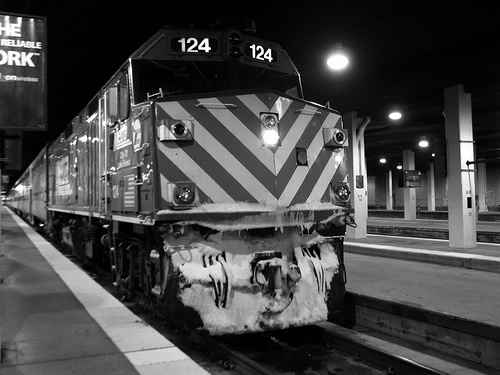

In [7]:
from PIL import Image

image = Image.open("VOCdevkit/VOC2012/JPEGImages/2007_000123.jpg")
display(image)

Each annotation describes the objects in an image:

In [8]:
!cat VOCdevkit/VOC2012/Annotations/2007_000123.xml

<annotation>
	<folder>VOC2012</folder>
	<filename>2007_000123.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>1</segmented>
	<object>
		<name>train</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1</xmin>
			<ymin>26</ymin>
			<xmax>358</xmax>
			<ymax>340</ymax>
		</bndbox>
	</object>
</annotation>


A Datasource is an object that reads data of a particular type. For example, Ray
implements a Datasource that reads CSV files.

Ray doesn't provide built-in support for Pascal VOC annotations, so you'll need to define a
custom datasource. To implement the datasource, extend the built-in `FileBasedDatasource` class
and override the `_read_file` method.

In [9]:
from typing import List, Tuple

import xmltodict
import pandas as pd
import pyarrow as pa

from ray.data.datasource import FileBasedDatasource
from ray.data.extensions import TensorArray


class VOCAnnotationDatasource(FileBasedDatasource):
    def _read_file(self, f: pa.NativeFile, path: str, **reader_args) -> pd.DataFrame:
        text = f.readall().decode("utf-8")
        annotation = xmltodict.parse(text)["annotation"]

        objects = annotation["object"]
        # If there's one object, `objects` is a `dict`; otherwise, it's a `list[dict]`.
        if isinstance(objects, dict):
            objects = [objects]

        boxes: List[Tuple] = []
        for obj in objects:
            x1 = float(obj["bndbox"]["xmin"])
            y1 = float(obj["bndbox"]["ymin"])
            x2 = float(obj["bndbox"]["xmax"])
            y2 = float(obj["bndbox"]["ymax"])
            boxes.append((x1, y1, x2, y2))

        labels: List[int] = [CLASS_TO_LABEL[obj["name"]] for obj in objects]

        filename = annotation["filename"]

        return pd.DataFrame(
            {
                "boxes": TensorArray([boxes]),
                "labels": TensorArray([labels]),
                "filename": [filename],
            }
        )

    def _rows_per_file(self):
        return 1

### Read annotations

To load the annotations into a `Dataset`, call `ray.data.read_datasource` and pass
your custom datasource to the constructor.

In [10]:
import os
import ray


root = os.path.abspath("./VOCdevkit/VOC2012")
annotations: ray.data.Dataset = ray.data.read_datasource(
    VOCAnnotationDatasource(), paths=os.path.join(root, "Annotations")
)
annotations.take(2)

2023-01-30 16:13:33,729	INFO worker.py:1242 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-30 16:13:35,048	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 172.31.137.156:9031...
2023-01-30 16:13:35,060	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_ejp4lxw5lzzfns6urety5xwjum/services?redirect_to=dashboard 
2023-01-30 16:13:35,558	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_e5973e2dee93b3ac64bbe8d05119a859.zip' (135.19MiB) to Ray cluster...
2023-01-30 16:13:37,840	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_e5973e2dee93b3ac64bbe8d05119a859.zip'.


[{'boxes': array([[174., 101., 349., 351.]]),
  'labels': 15,
  'filename': '2007_000027.jpg'},
 {'boxes': array([[104.,  78., 375., 183.],
         [133.,  88., 197., 123.],
         [195., 180., 213., 229.],
         [ 26., 189.,  44., 238.]]),
  'labels': array([ 1,  1, 15, 15]),
  'filename': '2007_000032.jpg'}]

### Load images into memory

Each row of `annotations` contains the filename of an image. Write a user-defined
function to open the images and add them to the dataset.

In [11]:
from typing import Dict

import numpy as np
from PIL import Image


def read_images(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    images: List[np.ndarray] = []
    for filename in batch["filename"]:
        path = os.path.join(root, "JPEGImages", filename)
        image = np.array(Image.open(path))
        images.append(image)
    batch["image"] = np.array(images, dtype=object)
    return batch


dataset = annotations.map_batches(read_images)
dataset

2023-01-30 16:13:42,395	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[read->MapBatches(read_images)]
read->MapBatches(read_images): 100%|██████████| 128/128 [00:09<00:00, 13.15it/s]


### Split the dataset into train and test sets

Once you've created a `Dataset`, split the dataset into train and test sets.

In [12]:
train_dataset, test_dataset = dataset.train_test_split(0.2)

## Define preprocessing logic

A `Preprocessor` is an object that defines preprocessing logic. It's the standard way
to preprocess data with Ray.

To preprocess the images, create a `TorchVisionPreprocessor` and call `transform` on the
dataset.


In [13]:
from torchvision import transforms

from ray.data.preprocessors import TorchVisionPreprocessor

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
    ]
)
train_preprocessor = TorchVisionPreprocessor(
    columns=["image"], transform=train_transform
)
train_dataset = train_preprocessor.transform(train_dataset)

test_transform = transforms.ToTensor()
test_preprocessor = TorchVisionPreprocessor(columns=["image"], transform=test_transform)
test_dataset = test_preprocessor.transform(test_dataset)

2023-01-30 16:13:53,664	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[TorchVisionPreprocessor]
TorchVisionPreprocessor: 100%|██████████| 103/103 [00:07<00:00, 13.06it/s]
2023-01-30 16:14:01,607	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[TorchVisionPreprocessor]
TorchVisionPreprocessor: 100%|██████████| 26/26 [00:01<00:00, 18.30it/s]


## Fine-tune the object detection model

### Define the training loop

Write a function that trains `fasterrcnn_resnet50_fpn`. Your
function should contain standard Torch code with the following changes:
1. Wrap your model with `ray.train.torch.prepare_model` instead of `DistributedDataParallel`.
2. Distribute data with `session.get_dataset_shard` instead of `DistributedSampler`.
3. Iterate over data with `DatasetIterator.iter_batches` instead of `DataLoader`.
5. Report metrics and checkpoints with `session.report`.

In [14]:
import torch
from torchvision import models

from ray.air import Checkpoint
from ray.air import session


def train_one_epoch(*, model, optimizer, batch_size, epoch):
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=250
        )

    device = ray.train.torch.get_device()
    train_dataset_shard = session.get_dataset_shard("train")

    batches = train_dataset_shard.iter_batches(batch_size=batch_size)
    for batch in batches:
        inputs = [torch.as_tensor(image).to(device) for image in batch["image"]]
        targets = [
            {
                "boxes": torch.as_tensor(boxes).to(device),
                "labels": torch.as_tensor(labels).to(device),
            }
            for boxes, labels in zip(batch["boxes"], batch["labels"])
        ]
        loss_dict = model(inputs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        session.report(
            {
                "losses": losses.item(),
                "epoch": epoch,
                "lr": optimizer.param_groups[0]["lr"],
                **{key: value.item() for key, value in loss_dict.items()},
            }
        )


def train_loop_per_worker(config):
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=21)
    model = ray.train.torch.prepare_model(model)
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        parameters,
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"],
    )
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=config["lr_steps"], gamma=config["lr_gamma"]
    )

    for epoch in range(0, config["epochs"]):
        train_one_epoch(
            model=model,
            optimizer=optimizer,
            batch_size=config["batch_size"],
            epoch=epoch,
        )
        lr_scheduler.step()
        checkpoint = Checkpoint.from_dict(
            {
                "model": model.module.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "config": config,
                "epoch": epoch,
            }
        )
        session.report({}, checkpoint=checkpoint)

### Fine-tune the model

Once you've defined the training loop, create a `TorchTrainer` and pass the training
loop to the constructor. Then, call `TorchTrainer.fit` to train the model.

In [15]:
from ray.air.config import ScalingConfig
from ray.train.torch import TorchTrainer


trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 2,
        "lr": 0.02,
        "epochs": 26,
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "lr_steps": [16, 22],
        "lr_gamma": 0.1,
    },
    scaling_config=ScalingConfig(num_workers=8, use_gpu=True),
    datasets={"train": train_dataset},
)
results = trainer.fit()

2023-01-30 16:14:03,238	INFO instantiator.py:21 -- Created a temporary directory at /tmp/tmpk4apom6q
2023-01-30 16:14:03,240	INFO instantiator.py:76 -- Writing /tmp/tmpk4apom6q/_remote_module_non_scriptable.py


(RayTrainWorker pid=55006) 2023-01-30 16:14:11,369	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=8]
(TorchTrainer pid=54896) 2023-01-30 16:14:12,187	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[randomize_block_order]
(RayTrainWorker pid=55006) 2023-01-30 16:14:16,356	INFO train_loop_utils.py:255 -- Moving model to device: cuda:1
(RayTrainWorker pid=55006) 2023-01-30 16:14:19,821	INFO train_loop_utils.py:315 -- Wrapping provided model in DistributedDataParallel.


Trial name,_time_this_iter_s,_timestamp,_training_iteration,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
TorchTrainer_2b137_00000,0.0146925,1675129814,22282,2023-01-30_17-50-16,True,,74f934afef444c1fa58c0278d635ba20,0,ip-172-31-137-156,22282,172.31.137.156,54896,True,5769.3,2.62141,5769.3,1675129816,0,,22282,2b137_00000,0.24938


2023-01-30 17:50:21,502	INFO tune.py:781 -- Total run time: 5778.18 seconds (5778.12 seconds for the tuning loop).


## Evaluate the model on test data

### Define a custom predictor

`Predictors` perform inference on batches of data.

To make `fasterrcnn_resnet50_fpn` outputs compatible with the `Predictor` interface,
subclass  `TorchPredictor` and override the `_predict_numpy` method.

In [16]:
import collections

from ray.train.torch import TorchPredictor
from ray.air.util.tensor_extensions.utils import create_possibly_ragged_ndarray


class CustomTorchPredictor(TorchPredictor):
    def _predict_numpy(
        self, data: np.ndarray, dtype: torch.dtype
    ) -> Dict[str, np.ndarray]:
        device = torch.device("cuda") if self.use_gpu else torch.device("cpu")
        inputs = [torch.as_tensor(image).to(device) for image in data["image"]]
        assert all(image.dim() == 3 for image in inputs)
        outputs = self.call_model(inputs)

        predictions = collections.defaultdict(list)
        for output in outputs:
            for key, value in output.items():
                predictions[key].append(value.cpu().detach().numpy())

        for key, value in predictions.items():
            predictions[key] = create_possibly_ragged_ndarray(value)
        predictions = {"pred_" + key: value for key, value in predictions.items()}
        return predictions

### Generate predictions on the test data

Create a `BatchPredictor` and pass `CustomTorchPredictor` to the constructor. Then,
call `BatchPredictor.predict` to detect objects in the test dataset.

In [17]:
from ray.train.batch_predictor import BatchPredictor


model = models.detection.fasterrcnn_resnet50_fpn(num_classes=21)
predictor = BatchPredictor.from_checkpoint(results.checkpoint, CustomTorchPredictor, model=model)

predictions = predictor.predict(
    test_dataset,
    feature_columns=["image"],
    keep_columns=["boxes", "labels"],
    batch_size=4,
    num_gpus_per_worker=1,
)
predictions

2023-01-30 17:50:24,491	INFO batch_predictor.py:184 -- `num_gpus_per_worker` is set for `BatchPreditor`.Automatically enabling GPU prediction for this predictor. To disable set `use_gpu` to `False` in `BatchPredictor.predict`.
2023-01-30 17:50:25,499	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(ScoringWrapper)]
MapBatches(ScoringWrapper), 0 (0 pending): 100%|██████████| 26/26 [02:59<00:00,  6.92s/it]


### Evaluate the model

Once you've created the `predictions` dataset, iterate over the rows of the dataset
and compute the accuracy of the model.

In [18]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision


metric = MeanAveragePrecision()
for row in predictions.iter_rows():
    preds = [
        {
            "boxes": torch.as_tensor(row["pred_boxes"]),
            "scores": torch.as_tensor(row["pred_scores"]),
            "labels": torch.as_tensor(row["pred_labels"]),
        }
    ]
    target = [
        {
            "boxes": torch.as_tensor(row["boxes"]),
            "labels": torch.as_tensor(row["labels"]),
        }
    ]
    metric.update(preds, target)

metric.compute()

{'map': tensor(0.3153),
 'map_50': tensor(0.6172),
 'map_75': tensor(0.2843),
 'map_small': tensor(0.0856),
 'map_medium': tensor(0.1662),
 'map_large': tensor(0.3766),
 'mar_1': tensor(0.3349),
 'mar_10': tensor(0.5406),
 'mar_100': tensor(0.5461),
 'mar_small': tensor(0.3381),
 'mar_medium': tensor(0.4680),
 'mar_large': tensor(0.5724),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}